In [45]:
import collections
import copy
import os
import random
import string
import time
import datetime
import pickle

import numpy as np
import pandas as pd
import math
from scipy import stats
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# %matplotlib notebook
# %matplotlib inline

In [2]:
data = pd.read_csv('Timeseries_Data.csv')
data = data.rename(index=int, columns={'Time Step': 't', 'Stress Ratio': 'S', 'Stress Ratio Change': 'dS/dt'})
data.head()

,t,S,dS/dt
0,1,0.319722,0.000000
1,2,0.319759,0.000036
2,3,0.319799,0.000041
3,4,0.319830,0.000031
4,5,0.319863,0.000033


### Initial Data Visualization

<IPython.core.display.Javascript object>


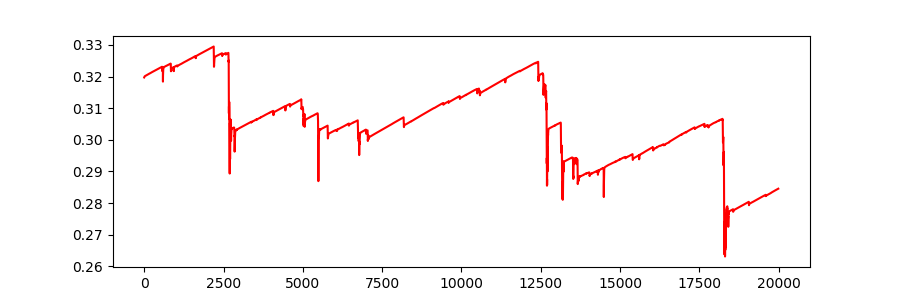

<IPython.core.display.Javascript object>


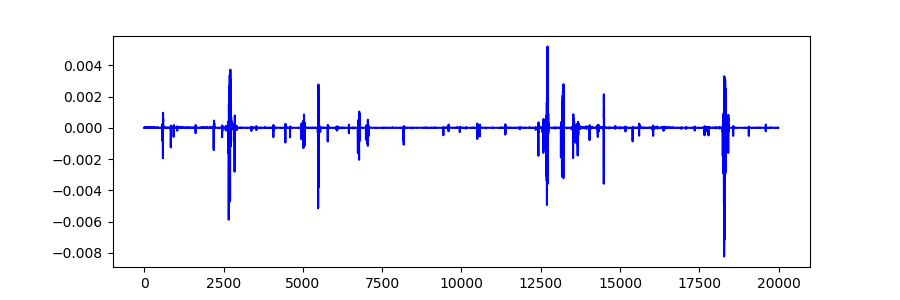

In [3]:
%matplotlib notebook

width = 9
height = width/5

plt.figure(1, figsize=(width,width/3))
plt.plot(data['S'], color = 'r')
plt.show()

plt.figure(2, figsize=(width,width/3))
plt.plot(data['dS/dt'], color = 'b')
plt.show()

### Distribution of $\frac{\partial S}{\partial t}$

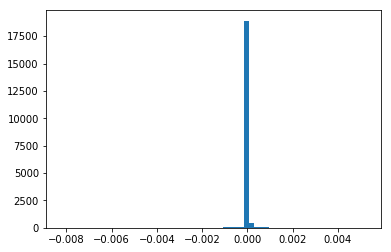

In [4]:
%matplotlib inline

plt.hist(data['dS/dt'], bins = 60)
plt.show()

#### Non-Normality of $\frac{\partial S}{\partial t}$

The following blocks demonstrate the non-normality of $\frac{\partial S}{\partial t}$ both with the Kolmogorov-Smirnov test and a visual comparison. The visual comparison also indicates that we should define events more tightly "than normal" with respect to the standard deviation of the data. 

In [5]:
normalized_dsdt = (data['dS/dt'] - data['dS/dt'].mean())/data['dS/dt'].std()
stats.kstest(normalized_dsdt, 'norm')

KstestResult(statistic=0.4473921795072221, pvalue=0.0)

In [6]:
normal_data = np.random.normal(0,1,20000)
stats.kstest(normal_data, 'norm')

KstestResult(statistic=0.005440401902102487, pvalue=0.5946478989689394)

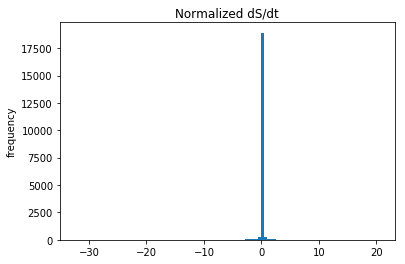

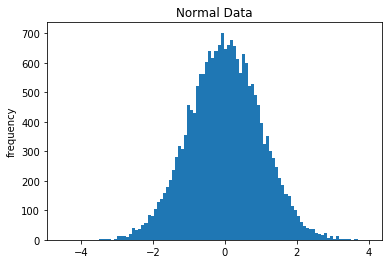

In [7]:
%matplotlib inline

plt.hist(normalized_dsdt, bins = 100)
plt.title('Normalized dS/dt')
plt.ylabel('frequency')
plt.show()

plt.hist(normal_data, bins = 100)
plt.title('Normal Data')
plt.ylabel('frequency')
plt.show()

## Data Processing

Event marking, data labeling and segmentation. 

In [30]:
# Event marker.

def event_marker(data, 
                 window_size = 4, 
                 enter_param = 1, 
                 leave_param = .5):
    std_dev = data['dS/dt'].std()
    mean = data['dS/dt'].mean()
    event_threshold = enter_param * std_dev
    leave_threshold = leave_param * std_dev
    
    # Mark Events with Ordinals
    event = np.zeros([len(data)], dtype = int)
    window = collections.deque(data['dS/dt'][0 : window_size] - mean, window_size)
    event_mark = 0
    mark = False
    for i in range(len(data) - (window_size + 1)):
        if not mark and (max(window) < -event_threshold):
            event_mark += 1
            mark = True
        elif mark and (max(window) < leave_threshold) and (min(window) > -leave_threshold):
            mark = False
        if mark:
            event[i] = event_mark
        window.append(data['dS/dt'][i + window_size + 1] - mean)
        data.loc[i, 'event'] = event_mark
    data['event'] = event
    
    # Record Event Magnitude
    event_mag = np.full([len(data)], np.nan)
    last_event = data['event'].max()
    for i in range(1, int(last_event) + 1):
        indices = data.loc[data['event'] == i].index.values
        values = data.loc[indices, 'S'].values
        magnitude = max(values) - min(values)
        event_mag[indices] = magnitude
    data['magnitude'] = event_mag
    
    # Time Since Last Event/Last Event Magnitude/Segment ID
    t_plus =np.full([len(data)], np.nan)
    last_mag = np.full([len(data)], np.nan)
    segment = np.full([len(data)], np.nan)
    magnitude = np.nan
    segment_id = 0
    time = False
    t = 1
    for i in range(1, len(data)):
        if time:
            t_plus[i] = t
            last_mag[i] = magnitude
            segment[i]= segment_id
            t += 1
        if data.loc[i, 'event'] > 0 and data.loc[i + 1, 'event'] == 0:
            time = True
            t = 1
            magnitude = data.loc[i, 'magnitude']
            segment_id += 1
        elif data.loc[i, 'event'] == 0 and data.loc[i + 1, 'event'] > 0:
            time = False
        if data.loc[i, 'event'] == last_event:
            break
    data['t+'] = t_plus
    data['last magnitude'] = last_mag
    data['segment'] = segment
    
    # Time Until Next Event/Magnitude of Next Event
    t_minus = np.full([len(data)], np.nan)
    next_mag = np.full([len(data)], np.nan)
    magnitude = np.nan
    time = False
    t = 1
    for i in range(len(data) - 1, 1, -1):
        if time:
            t_minus[i] = t
            next_mag[i] = magnitude
            t += 1
        if data.loc[i, 'event'] > 0 and data.loc[i - 1, 'event'] == 0:
            time = True
            t = 1
            magnitude = data.loc[i, 'magnitude']
        elif data.loc[i, 'event'] == 0 and data.loc[i - 1, 'event'] > 0:
            time = False
        if data.loc[i, 'event'] == 1:
            break
    data['t-'] = t_minus 
    data['next magnitude'] = next_mag 
    return data

data = event_marker(data)

In [9]:
data[599:2667]

,t,S,dS/dt,event,magnitude,t+,last magnitude,segment,t-,next magnitude
599,600,0.322146,0.000098,1,0.004349,NaN,NaN,NaN,NaN,NaN
600,601,0.322310,0.000164,0,NaN,1.0,0.004349,1.0,1591.0,0.006412
601,602,0.322323,0.000013,0,NaN,2.0,0.004349,1.0,1590.0,0.006412
602,603,0.322375,0.000052,0,NaN,3.0,0.004349,1.0,1589.0,0.006412
603,604,0.322495,0.000120,0,NaN,4.0,0.004349,1.0,1588.0,0.006412
604,605,0.322556,0.000061,0,NaN,5.0,0.004349,1.0,1587.0,0.006412
605,606,0.322590,0.000034,0,NaN,6.0,0.004349,1.0,1586.0,0.006412
606,607,0.322628,0.000039,0,NaN,7.0,0.004349,1.0,1585.0,0.006412
607,608,0.322685,0.000056,0,NaN,8.0,0.004349,1.0,1584.0,0.006412
608,609,0.322748,0.000063,0,NaN,9.0,0.004349,1.0,1583.0,0.006412


<IPython.core.display.Javascript object>


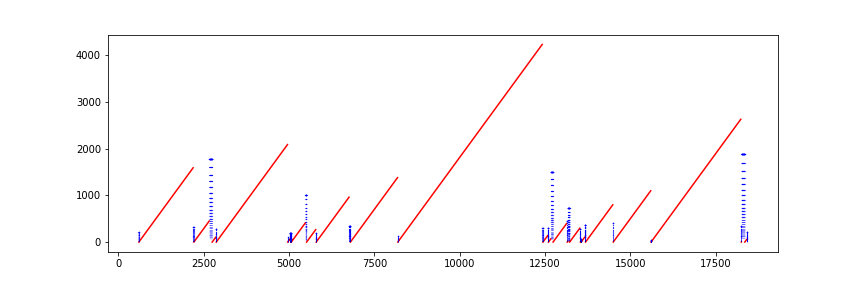

In [11]:
%matplotlib notebook
%matplotlib notebook

width = 12
mag_scale = 50000
plt.figure(figsize=(width,width/3))
plt.plot(data['t+'], color = 'r')
plt.plot(data['magnitude'] * mag_scale, '.', color = 'b', label = 'Scaled Magnitude', markersize = .3)
for i in range(1, 100):
    scale_factor = .9**i
    plt.plot(data['magnitude'] * mag_scale * scale_factor, '.', color = 'b', markersize = .1 * scale_factor)
plt.show()

<IPython.core.display.Javascript object>


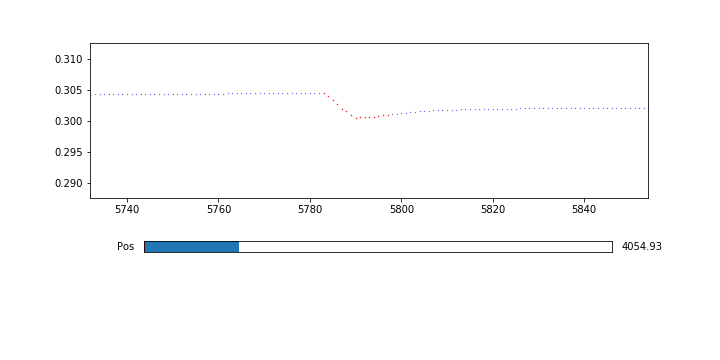

In [31]:
%matplotlib notebook

fig, ax = plt.subplots(figsize = (10,5))
plt.subplots_adjust(bottom=0.45)

non_event_data = data.loc[data['event'] == 0]
event_data = data.loc[data['event'] > 0]

plot_min = data['S'].min() - .01
plot_max = data['S'].max() + .01

nt = non_event_data['t']
nS = non_event_data['S']
et = event_data['t']
eS = event_data['S']

l1, = plt.plot(nt,nS, '.', color = 'b', markersize = .5)
l2, = plt.plot(et,eS, '.', color = 'r', markersize = 1)

plt.axis([0, 4000, plot_min, plot_max])

axpos = plt.axes([0.2, 0.3, 0.65, 0.03])

spos = Slider(axpos, 'Pos', 0, len(data))

def update(val):
    pos = spos.val
    ax.axis([pos,pos+5000, plot_min, plot_max])
    fig.canvas.draw_idle()

spos.on_changed(update)

plt.show()

In [32]:
def generate_code(length = 4):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

def save_segments_to_disk(data, project_name):
    working_directory = os.getcwd()
    path = os.path.join(working_directory, project_name)
    path_str = str(path)
    if project_name not in os.listdir(os.getcwd()):
        try:
            os.mkdir(path)
        except:
            print("%s directory not created, save failed." % path_str)
            return None
    save_code = generate_code()
    print('Save code: ' + save_code)
    save_code += '_'
    saved_columns = ['t', 'S', 'dS/dt', 't+', 'last magnitude', 't-', 'next magnitude']
    num_segments = int(data['segment'].max())
    for i in range(num_segments):
        segment_name = save_code + str(i)
        segment_path = os.path.join(path, segment_name)
        segment = data.loc[data['segment'] == i + 1]
        save_segment = segment[saved_columns]
        save_segment.to_csv(segment_path, index = None, header=True)

save_segments_to_disk(data, 'Fault_Slip_Data')

Save code: veqn


## Segment $\frac{\partial S}{\partial t}$ Visualization

Unique dS/dt values: 2169


<IPython.core.display.Javascript object>


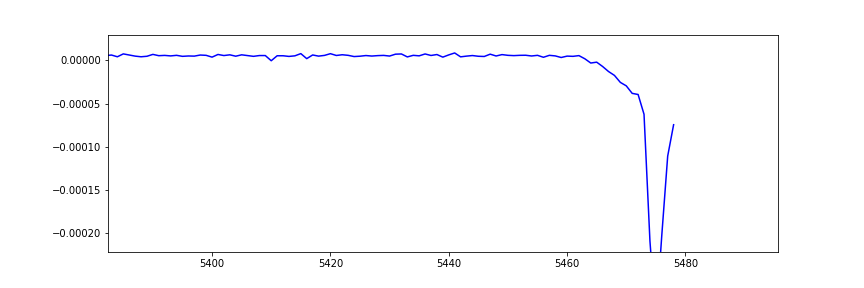

In [33]:
%matplotlib notebook

segment_data = data.loc[data['segment'] >= 1]

print("Unique dS/dt values: %d"%len(np.unique(segment_data['dS/dt'].values)))

if len(data) > len(segment_data):
    for i in range(int(segment_data['segment'].max())):
        segment = segment_data.loc[segment_data['segment'] == i + 1]
        plt.figure(2, figsize=(width,width/3))
        plt.plot(segment['t'], segment['dS/dt'], color = 'b')
    plt.show()

# Step2Vec

### Example Corpus Construction

In [34]:
project_name = 'Fault_Slip_Data'

def build_dictionary_and_corpus(project_name):
    dictionary = dict()
    corpus = [-1]
    project_path = os.path.join(os.getcwd(), project_name)
    segment_names = os.listdir(project_path)
    entry = 0
    for name in segment_names:
        segment = pd.read_csv(os.path.join(project_path, name))
        values = segment['dS/dt'].values
        for i in range(len(values)):
            value = values[i]
            if not value in dictionary.keys():
                dictionary[value] = entry
                entry += 1
        for i in range(len(values)):
            value = values[i]
            corpus.append(dictionary[value])
        corpus.append(-1)
    reverse_dictionary = dict(zip(dict(dictionary).values(), dict(dictionary).keys()))
    frequency_dictionary = collections.Counter(corpus)
    return corpus, dictionary, reverse_dictionary, frequency_dictionary

In [35]:
corpus, dictionary, reverse_dictionary, frequency_dictionary = build_dictionary_and_corpus(project_name)
for i in range(100):
    print(corpus[2000 + i], end = ' ')

35 37 65 44 19 46 49 388 31 60 31 50 31 45 41 19 43 80 31 29 72 82 33 37 33 38 37 40 87 22 66 29 46 47 60 60 197 309 65 54 47 29 65 46 53 30 51 69 331 33 22 33 62 53 57 65 80 29 31 49 87 49 57 66 80 65 42 39 40 82 58 37 37 57 30 49 114 47 72 42 37 38 33 72 86 43 73 31 81 69 66 287 31 65 31 22 80 31 37 30 

In [36]:
print('%d unique values recorded.'%len(dictionary), end = '\n\n')
for i in range(10):
    print('Key: '+str(list(dictionary.keys())[i]), end = ', ')
    print('Value: '+str(list(dictionary.values())[i]))

2169 unique values recorded.

Key: 0.000127334, Value: 0
Key: 9.98e-05, Value: 1
Key: 9.01e-05, Value: 2
Key: 8.4e-05, Value: 3
Key: 6.409999999999999e-05, Value: 4
Key: 7.04e-05, Value: 5
Key: 4.320000000000001e-05, Value: 6
Key: 5.7200000000000015e-05, Value: 7
Key: 3.41e-05, Value: 8
Key: 3.65e-05, Value: 9


### Example Batch Generator

In [37]:
data_index = 0
left_right_index = [0,0]
subsample_indices = []

def subsample_keep_probability(frequency_ratio, parameter = 0.01):
    return min(1, (math.sqrt(frequency_ratio/parameter)+1)*parameter/frequency_ratio)

def generate_embedding_batch(corpus, 
                             batch_size = None, 
                             n_left = 2, 
                             n_right = 2, 
                             subsample = True, 
                             subsample_parameter = 0.01):
    global data_index
    global left_right_index
    global subsample_indices
    corpus_size = len(corpus)
    assert isinstance(batch_size, int), "Batch Generator: You must specify a batch size."
    batch = np.ndarray(shape=(batch_size), dtype = np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype = np.int32)
    record_position = 0
    corpus_size = len(corpus)
    while record_position < batch_size:
        if subsample and corpus[data_index] in subsample_indices:
            data_index = (data_index + 1) % corpus_size
            continue
        
        if corpus[data_index] == -1:
            data_index = (data_index + 1) % corpus_size
            continue
            
        for i in range(left_right_index[0], n_left):
            if record_position == batch_size:
                break
            if corpus[data_index - 1 - i] == -1:
                break
            if subsample == True and corpus[data_index-1-i] in subsample_indices:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index - 1 - i]
                left_right_index[0] += 1
                record_position += 1
                
        for i in range(left_right_index[1], n_right):
            if record_position == batch_size:
                break
            if corpus[data_index + 1 + i] == -1:
                break
            if subsample and corpus[data_index+1+i] in subsample_indices:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index + 1 + i]
                left_right_index[1] += 1
                record_position += 1
                 
        if record_position == batch_size:
            break

        if subsample:
            frequency_ratio = frequency_dictionary[corpus[data_index]]/corpus_size 
            probability = subsample_keep_probability(frequency_ratio, parameter = subsample_parameter)
            sample = random.uniform(0,1)
            if sample > probability:
                subsample_indices.append(corpus[data_index])
        data_index = (data_index + 1) % corpus_size
        word_recorded = False
        left_right_index = [0,0]
    return batch, labels

In [39]:
data_index = 0
example_batch, example_labels = generate_embedding_batch(corpus, batch_size = 12)
print("Example Time Series Data:")
for i in range(1,10):
    print(reverse_dictionary[corpus[i]], end = " ")
print(" ")
print("Example Numerical Pairs:")
print(example_batch)
print(example_labels)

Example Time Series Data:
0.000127334 9.98e-05 9.01e-05 8.4e-05 6.409999999999999e-05 7.04e-05 4.320000000000001e-05 5.7200000000000015e-05 3.41e-05  
Example Numerical Pairs:
[0 1 1 1 2 2 2 2 3 3 3 3]
[[2]
 [0]
 [2]
 [3]
 [1]
 [0]
 [3]
 [4]
 [2]
 [1]
 [4]
 [5]]


### Example Embedding Graph

In [40]:
embedding_size = len(dictionary)
embedding_dimension = 64
number_negative_samples = 64
batch_size = 128

Step2VecSG_graph = tf.Graph()

with Step2VecSG_graph.as_default():
    # Input: Integer indices of rows to look up. 
    train_data = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    
    # Variables
    embeddings = tf.Variable(tf.random_uniform([embedding_size, embedding_dimension],
                                               minval = -1.0,
                                               maxval = 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([embedding_size, embedding_dimension],
                                                      stddev = 1.0/math.sqrt(embedding_dimension)))
    softmax_biases = tf.Variable(tf.zeros([embedding_size]))
    
    # Model.
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    sampled_softmax_loss = tf.nn.sampled_softmax_loss(weights=softmax_weights, 
                               biases = softmax_biases, 
                               inputs = embed,
                               labels = train_labels, 
                               num_sampled = number_negative_samples, 
                               num_classes = embedding_size)
    
    loss = tf.reduce_mean(sampled_softmax_loss)
    
    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Normalized embeddings.
    embedding_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings/embedding_norm

#### Make this more graceful.

In [41]:
training_time = 20 # minutes
report_frequency = 30000 # by iteration

# Clear subsampled indices before each from-scratch training session. 
subsample_indices = []

# Start with no subsampling. 
subsample_trigger = False
subsample_param = .1

with tf.Session(graph = Step2VecSG_graph) as session:
    start_time = time.time()
    run_time = 0
    tf.global_variables_initializer().run()
    print('Variables Initialized')
    average_loss = 0
    iteration = 0
    checkpoint = [5., 10., 15., 20., 25., 30., 35.]
    checkpoint_index = 0
    while run_time < training_time*60:
        batch_data, batch_labels = generate_embedding_batch(corpus,
                                                             batch_size = batch_size, 
                                                             subsample = subsample_trigger,
                                                             subsample_parameter = subsample_param)
        feed_dict = {train_data : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        run_time = time.time() - start_time
        average_loss += l
        if iteration % report_frequency == 0 and iteration > 0:
            average_loss = average_loss / report_frequency
            print('Average loss at iteration %d: %f' % (iteration, average_loss))
            print('Number of subsampled indices: %d' % len(subsample_indices))
            average_loss = 0
        iteration += 1
        run_time_min = run_time/60
        if run_time_min > checkpoint[checkpoint_index]:
            print("Run time: %f minutes." % run_time_min)
            subsample_trigger = True
            subsample_param = subsample_param*.1
            print("Subsample Parameter: %f." % subsample_param)
            checkpoint_index += 1
    Step2Vec_embeddings = normalized_embeddings.eval()
    print('Embedding complete.')

Variables Initialized
Average loss at iteration 30000: 1.998629
Number of subsampled indices: 0
Average loss at iteration 60000: 1.728261
Number of subsampled indices: 0
Average loss at iteration 90000: 1.679598
Number of subsampled indices: 0
Average loss at iteration 120000: 1.662909
Number of subsampled indices: 0
Average loss at iteration 150000: 1.644735
Number of subsampled indices: 0
Average loss at iteration 180000: 1.627822
Number of subsampled indices: 0
Average loss at iteration 210000: 1.626658
Number of subsampled indices: 0
Run time: 5.000131 minutes.
Subsample Parameter: 0.010000.
Average loss at iteration 240000: 1.612449
Number of subsampled indices: 0
Average loss at iteration 270000: 1.608429
Number of subsampled indices: 0
Average loss at iteration 300000: 1.602251
Number of subsampled indices: 0
Average loss at iteration 330000: 1.595544
Number of subsampled indices: 0
Average loss at iteration 360000: 1.596433
Number of subsampled indices: 0
Average loss at iterat

In [23]:
Step2Vec_embeddings[0]

array([-0.05672921, -0.13524453, -0.13661559, -0.00454746,  0.05236039,
        0.13960773,  0.1551208 , -0.08888342,  0.09622437, -0.18789484,
        0.04627733, -0.01650277,  0.07130639,  0.04703951, -0.02836622,
       -0.07337619, -0.05612396, -0.20227621,  0.16421068, -0.03461532,
       -0.10449227, -0.04286376,  0.1146256 , -0.09636831,  0.08197579,
        0.23452899, -0.09401217,  0.06935691, -0.32460657, -0.2314581 ,
        0.23548412,  0.14953704, -0.16815068, -0.02812705, -0.09667491,
        0.1723173 , -0.12964764, -0.11604888,  0.14285052, -0.00140803,
       -0.04800553,  0.10164414, -0.04870503,  0.03649042,  0.15077701,
       -0.12972474, -0.03343612, -0.04365735, -0.1602094 , -0.09840295,
        0.13212958,  0.01814959, -0.0288941 , -0.18613988, -0.05758147,
        0.09321427, -0.09509428,  0.15805247,  0.0751209 , -0.06291903,
        0.2899215 , -0.06716039, -0.03262412, -0.11837722], dtype=float32)

In [46]:
def save_embeddings(embeddings, 
                    corpus, 
                    dictionary, 
                    reverse_dictionary, 
                    frequency_dictionary, 
                    save_corpus = True, 
                    project_name = False):
    if not project_name:
        embedding_name = "Embed_" + str(datetime.datetime.now())[:19].replace(" ","_").replace(":",".")
    else:
        embedding_name = str(project_name) + "_Embed_" + str(datetime.datetime.now())[:19].replace(" ","_").replace(":",".")
    working_directory = os.getcwd()
    target_directory = embedding_name
    path = os.path.join(working_directory, target_directory)
    path_str = str(path)
    date_time_stamp = str(datetime.datetime.now())[:19].replace(" ","_").replace(":",".")
    try:
        os.mkdir(path)
    except:
        print("%s directory not made, save failed." % path)
        return None
    # Save embeddings.
    np.save(os.path.join(path, embedding_name), embeddings)
    embedding_name += ".npy"
    # Save corpus if desired.
    if save_corpus:
        corpus_name = "Corpus_" + date_time_stamp
        with open(path_str + "/" + corpus_name + ".pickle", "wb") as filename:
            pickle.dump(corpus, filename)
    # Save dictionary.
    dictionary_name = "Dictionary_" + date_time_stamp
    with open(path_str + "/" + dictionary_name + ".pickle", "wb") as filename:
        pickle.dump(dictionary, filename)
    # Save reverse dictionary.
    reverse_dictionary_name = "RevDictionary_" + date_time_stamp
    with open(path_str + "/" + reverse_dictionary_name + ".pickle", "wb") as filename:
        pickle.dump(reverse_dictionary, filename)
    # Save frequency dictionary.
    frequency_dictionary_name = "FreqDictionary_" + date_time_stamp
    with open(path_str + "/" + frequency_dictionary_name + ".pickle", "wb") as filename:
        pickle.dump(frequency_dictionary, filename)
    
    print("Embeddings saved as: " + embedding_name)
    return embedding_name
    
saved_array = save_embeddings(Step2Vec_embeddings, 
                              corpus, 
                              dictionary, 
                              reverse_dictionary, 
                              frequency_dictionary, 
                              project_name = project_name)

Embeddings saved as: Fault_Slip_Data_Embed_2019-11-02_10.04.02.npy


### Task 1: Predict Instability

Simple classification, with labels of unstable for any unrollings with $t-\leq n$ for a given $n$ and stable otherwise.  This is a binary classification task, with selection from all events.  Then, train and test data will be decided.  This is not how it should be done generally, but this is to ease into the more difficult tasks while data is forthcoming. 

#### Read Segment Data into List

In [48]:
def get_segments(project_name):
    project_path = os.path.join(os.getcwd(), project_name)
    segment_names = os.listdir(project_path)
    segments = list()
    for name in segment_names:
        segment = pd.read_csv(os.path.join(project_path, name))
        segments.append(segment)
    return segments

segments = get_segments(project_name)

#### Data Hyperparameters

In [280]:
sequence_length = 20
stable_n = 5

#### Sequence Structure

Sequence includes $n=$ `sequence_length` sequential data points, each with the $\frac{\partial S}{\partial t}$ embedded array concatenated with that timestep's $S$, $t+$, and `last manitude`.

In [281]:
def label_segment(segment):
    labels = np.zeros([len(segment)])
    labels[-stable_n:] = 1
    segment['label'] = labels
    return segment

def label_segments(segments):
    for segment in segments:
        segment = label_segment(segment)
    return segments

segments = label_segments(segments)

In [282]:
vector_dimension = embedding_dimension + 3

def build_segment_array(segment, embedding_vectors, vector_dimension):
    segment_array = np.full([len(segment) - sequence_length + 1, sequence_length, vector_dimension], np.nan)
    labels_array = np.zeros([len(segment) - sequence_length + 1, 2])
    for i in range(len(segment) - sequence_length + 1):
        for j in range(sequence_length):
            vec = embedding_vectors[dictionary[segment['dS/dt'][i + j]]]
            S = np.full([1], segment['S'][i + j])
            t_plus = np.full([1], segment['t+'][i + j])
            last_mag = np.full([1], segment['last magnitude'][i + j])
            segment_array[i,j] = np.concatenate((vec, S, t_plus, last_mag))
        if i <= len(segment) - (stable_n + sequence_length):
            labels_array[i, 0] = 1
        else:
            labels_array[i, 1] = 1
    return segment_array, labels_array

In [283]:
def data_and_labels(segments, embedding_vectors, vector_dimension):
    data_and_labels = list()
    for i in range(len(segments)):
        instance = list()
        data, labels = build_segment_array(segments[i], embedding_vectors, vector_dimension)
        instance.append(data)
        instance.append(labels)
        data_and_labels.append(instance)
    return data_and_labels

data_and_labels = data_and_labels(segments, Step2Vec_embeddings, vector_dimension)

In [284]:
# stack data and labels

def stack_data_and_labels(data_and_labels):
    data = data_and_labels[0][0]
    labels = data_and_labels[0][1]
    for i in range(1, len(data_and_labels)):
        data = np.concatenate((data, data_and_labels[i][0]), axis = 0)
        labels = np.concatenate((labels, data_and_labels[i][1]), axis = 0)
    return data, labels

data, labels = stack_data_and_labels(data_and_labels)

In [285]:
# random balance selection of stable and unstable datapoints

def train_test_split(data, 
                     labels, 
                     split_ratio = .8, 
                     seed = None, 
                     report = True, 
                     upsample_train = True, 
                     upsample_test = True, 
                     train_difference = None):
    stable_indices = list()
    unstable_indices = list()
    for i in range(len(labels)):
        if labels[i,0] == 1:
            stable_indices.append(i)
        else:
            unstable_indices.append(i)
    # shuffle indices
    random.seed(seed)
    random.shuffle(stable_indices)
    random.shuffle(unstable_indices)
    # get and shuffle indices
    stable_selection = int(len(stable_indices)*split_ratio)
    unstable_selection = int(len(unstable_indices)*split_ratio)
    train_stable_indices = stable_indices[:stable_selection]
    train_unstable_indices = unstable_indices[:unstable_selection]
    test_stable_indices = stable_indices[stable_selection:]
    test_unstable_indices = unstable_indices[unstable_selection:]
    # Upsampling
    train_upsampling = list() # dummy list for list arithmetic
    test_upsampling = list()
    if upsample_train:
        if not train_difference:
            train_difference = len(train_stable_indices) - len(train_unstable_indices)
        train_upsampling = random.choices(train_unstable_indices, k = train_difference)
    train_indices = train_stable_indices + train_unstable_indices + train_upsampling
    random.shuffle(train_indices)
    if upsample_test:
        test_difference = len(test_stable_indices) - len(test_unstable_indices)
        test_upsampling = random.choices(test_unstable_indices, k = test_difference)
    test_indices = test_stable_indices + test_unstable_indices + test_upsampling
    random.shuffle(test_indices)
    # select data and labels
    train_data = data[train_indices]
    train_labels = labels[train_indices]
    test_data = data[test_indices]
    test_labels = labels[test_indices]
    if report:
        print('Train difference: %d' % train_difference)
        print('Test difference: %d' % test_difference)
        print('Number of stable training points: ' + str(len(train_stable_indices)))
        print('Number of unstable training points: ' + str(len(train_unstable_indices + train_upsampling)))
        print('Number of stable test points: ' + str(len(test_stable_indices)))
        print('Number of unstable test points: ' + str(len(test_unstable_indices + test_upsampling)))
    return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = train_test_split(data, labels)

Train difference: 12148
Test difference: 3037
Number of stable training points: 12203
Number of unstable training points: 12203
Number of stable test points: 3051
Number of unstable test points: 3051


# Classifier 1:

### Batch Generator

In [286]:
batch_size = 64
number_of_classes = 2
vector_dimension = embedding_dimension + 3
data_index = 0
epoch = 0

def generate_LSTM_batch(data, labels, batch_size, sequence_length, vector_dimension):
    global data_index
    global epoch
    if data_index + batch_size >= len(data):
        epoch += 1
    batch = np.zeros(shape=(batch_size, sequence_length, vector_dimension), dtype=np.float32)
    labels_out = np.zeros(shape=(batch_size, number_of_classes), dtype=np.float32)
    for i in range(batch_size):
        batch[i] = data[data_index]
        labels_out[i] = labels[data_index]
        data_index = (data_index + 1) % len(data)
    return batch, labels_out, epoch

In [287]:
sample_batch, sample_labels, _ = generate_LSTM_batch(data, labels, batch_size, sequence_length, vector_dimension)
print(sample_batch.shape)
print(sample_labels.shape)

(64, 20, 67)
(64, 2)


### Graph

In [293]:
### Hyperparameters ###
number_of_nodes = 64
initial_learning_rate = 1.
init_truncation = .1
#######################

BiLSTM_graph = tf.Graph()
with BiLSTM_graph.as_default():
    # Input
    T = tf.placeholder(tf.float32, shape = [batch_size, sequence_length, vector_dimension])
    Tlabel = tf.placeholder(tf.float32, shape = [batch_size, number_of_classes])
    E = tf.constant(test_data, dtype = tf.float32)
    
    # Forward LSTM variables
    # Input gate.
    X_if = tf.Variable(tf.truncated_normal([vector_dimension, number_of_nodes], -init_truncation, init_truncation))
    M_if = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -init_truncation, init_truncation))
    b_if = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Forget gate.
    X_ff = tf.Variable(tf.truncated_normal([vector_dimension, number_of_nodes], -init_truncation, init_truncation))
    M_ff = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -init_truncation, init_truncation))
    b_ff = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Memory cell.                             
    X_cf = tf.Variable(tf.truncated_normal([vector_dimension, number_of_nodes], -init_truncation, init_truncation))
    M_cf = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -init_truncation, init_truncation))
    b_cf = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Output gate.
    X_of = tf.Variable(tf.truncated_normal([vector_dimension, number_of_nodes], -init_truncation, init_truncation))
    M_of = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -init_truncation, init_truncation))
    b_of = tf.Variable(tf.zeros([1, number_of_nodes]))
    
    # Backward LSTM variables
    # Input gate.
    X_ib = tf.Variable(tf.truncated_normal([vector_dimension, number_of_nodes], -init_truncation, init_truncation))
    M_ib = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -init_truncation, init_truncation))
    b_ib = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Forget gate.
    X_fb = tf.Variable(tf.truncated_normal([vector_dimension, number_of_nodes], -init_truncation, init_truncation))
    M_fb = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -init_truncation, init_truncation))
    b_fb = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Memory cell.                             
    X_cb = tf.Variable(tf.truncated_normal([vector_dimension, number_of_nodes], -init_truncation, init_truncation))
    M_cb = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -init_truncation, init_truncation))
    b_cb = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Output gate.
    X_ob = tf.Variable(tf.truncated_normal([vector_dimension, number_of_nodes], -init_truncation, init_truncation))
    M_ob = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -init_truncation, init_truncation))
    b_ob = tf.Variable(tf.zeros([1, number_of_nodes]))
    
    # Attention variables.
    # Context vector.
    C_attn = tf.Variable(tf.truncated_normal([number_of_nodes , 1], -init_truncation, init_truncation))
    # Attention weights and biases.
    W_attn = tf.Variable(tf.truncated_normal([2*number_of_nodes, number_of_nodes], -init_truncation, init_truncation))
    b_attn = tf.Variable(tf.zeros([number_of_nodes]))
    
    # Classifier weights and biases.
    W = tf.Variable(tf.truncated_normal([2*number_of_nodes, number_of_classes], -init_truncation, init_truncation))
    b = tf.Variable(tf.zeros([number_of_classes]))
    
    # Initialize time 0 state and previous output. 
    initial_output = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
    initial_state = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
     
    def forward_LSTM_cell(sequence_element, previous_output, state):
        input_gate = tf.sigmoid(tf.matmul(sequence_element, X_if) + tf.matmul(previous_output, M_if) + b_if)
        forget_gate = tf.sigmoid(tf.matmul(sequence_element, X_ff) + tf.matmul(previous_output, M_ff) + b_ff)
        update = tf.matmul(sequence_element, X_cf) + tf.matmul(previous_output, M_cf) + b_cf
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(sequence_element, X_of) + tf.matmul(previous_output, M_of) + b_of)
        return output_gate * tf.tanh(state), state
    
    def backward_LSTM_cell(sequence_element, previous_output, state):
        input_gate = tf.sigmoid(tf.matmul(sequence_element, X_ib) + tf.matmul(previous_output, M_ib) + b_ib)
        forget_gate = tf.sigmoid(tf.matmul(sequence_element, X_fb) + tf.matmul(previous_output, M_fb) + b_fb)
        update = tf.matmul(sequence_element, X_cb) + tf.matmul(previous_output, M_cb) + b_cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(sequence_element, X_ob) + tf.matmul(previous_output, M_ob) + b_ob)
        return output_gate * tf.tanh(state), state

    # Unrolled LSTM loops.
    def forward_LSTM_loop(data, sequence_length, initial_output, initial_state):
        outputs = list()
        output = initial_output
        state = initial_state
        for i in range(sequence_length):
            output, state = forward_LSTM_cell(data[:,i], output, state)
            outputs.append(output)
        return outputs
    
    def backward_LSTM_loop(data, sequence_length, initial_output, initial_state):
        outputs = list()
        output = initial_output
        state = initial_state
        for i in range(sequence_length):
            output, state = backward_LSTM_cell(data[:,-i-1], output, state)
            outputs.append(output)
        return outputs
    
    def back_and_forth_concat(forward_outputs, backward_outputs, sequence_length):
        outputs = list()
        for i in range(sequence_length):
            output = tf.concat([forward_outputs[i], backward_outputs[-i-1]], axis = 1)
            outputs.append(output)
        return outputs
    
    # Attention model:
    def attention_layer(outputs, W_attn, b_attn, C_attn):
        U = list()
        for i in range(len(outputs)):
            u = tf.tanh(tf.nn.xw_plus_b(outputs[i], W_attn, b_attn))
            U.append(u)
    
        C = list()
        for i in range(len(U)):
            c = tf.matmul(U[i], C_attn)
            C.append(c)
    
        C_concat = tf.concat(C, 1)
        S = tf.nn.softmax(C_concat, 1)
        
        attn_outputs = list()
        for i in range(sequence_length):
            attn_output = tf.multiply(outputs[i], S[:,i][:, tf.newaxis])
            attn_outputs.append(attn_output)
        return attn_outputs, S
    
    # Model.
    forward_outputs = forward_LSTM_loop(T, sequence_length, initial_output, initial_state)
    backward_outputs = backward_LSTM_loop(T, sequence_length, initial_output, initial_state)
    outputs = back_and_forth_concat(forward_outputs, backward_outputs, sequence_length)
    attn_outputs, S = attention_layer(outputs, W_attn, b_attn, C_attn)
    
    # Compute logits and loss for attention-weighted sum of outputs.
    L = tf.nn.xw_plus_b(tf.math.add_n(attn_outputs), W, b)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = Tlabel, logits=L))
    
    # Decaying learning rate for optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, 1000, 0.1, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)    
    
    # Apply gradient clipping. 
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)
    
    # Training predictions. 
    train_predict = tf.nn.softmax(L)
    
    # Test predictions. 
    
    # Initialize output, state at origin. 
    test_initial_output = tf.Variable(tf.zeros([len(test_data), number_of_nodes]), trainable = False)
    test_initial_state = tf.Variable(tf.zeros([len(test_data), number_of_nodes]), trainable = False)
    
    test_forward_outputs = forward_LSTM_loop(E, sequence_length, test_initial_output, test_initial_state)
    test_backward_outputs = backward_LSTM_loop(E, sequence_length, test_initial_output, test_initial_state)
    test_outputs = back_and_forth_concat(test_forward_outputs, test_backward_outputs, sequence_length)
    test_attn_outputs, _ = attention_layer(test_outputs, W_attn, b_attn, C_attn)
    test_predict = tf.nn.softmax(tf.nn.xw_plus_b(tf.math.add_n(test_attn_outputs), W, b))
    
    # Example generator.
    #evaluation_example = tf.constant(example_data)
    
    #example_initial_output = tf.Variable(tf.zeros([1, number_of_nodes]), trainable = False)
    #example_initial_state = tf.Variable(tf.zeros([1, number_of_nodes]), trainable = False)
    
    #example_forward_outputs = forward_LSTM_loop(evaluation_example, number_of_unrollings, example_initial_output, example_initial_state)
    #example_backward_outputs = backward_LSTM_loop(evaluation_example, number_of_unrollings, example_initial_output, example_initial_state)
    #example_outputs = back_and_forth_concat(example_forward_outputs, example_backward_outputs, sequence_length)
    #example_attn_outputs, S_example = attention_layer(example_outputs, W_attn, b_attn, C_attn)
    #example_predict = tf.nn.softmax(tf.nn.xw_plus_b(tf.math.add_n(example_attn_outputs), W, b))

### Session

In [294]:
def first_order_accuracy(predicted_labels, true_labels):
    return(100*np.sum(np.argmax(predicted_labels, 1)==np.argmax(true_labels, 1))
           /predicted_labels.shape[0])

Initialized
Epoch 10 complete.
50.0
Epoch 20 complete.
46.875
Epoch 30 complete.
43.75
Epoch 40 complete.
73.4375
Epoch 50 complete.
71.875
Epoch 60 complete.
71.875
Epoch 70 complete.
67.1875
Epoch 80 complete.
75.0
Epoch 90 complete.
75.0
Epoch 100 complete.
71.875
Epoch 110 complete.
73.4375
Epoch 120 complete.
73.4375
Epoch 130 complete.
73.4375
Epoch 140 complete.
68.75
Epoch 150 complete.
75.0
Epoch 160 complete.
78.125
Epoch 170 complete.
70.3125
Epoch 180 complete.
75.0
Epoch 190 complete.
71.875
Epoch 200 complete.
73.4375
Epoch 210 complete.
71.875
Epoch 220 complete.
71.875
Epoch 230 complete.
67.1875
Epoch 240 complete.
75.0
Epoch 250 complete.
75.0
Epoch 260 complete.
71.875


<IPython.core.display.Javascript object>


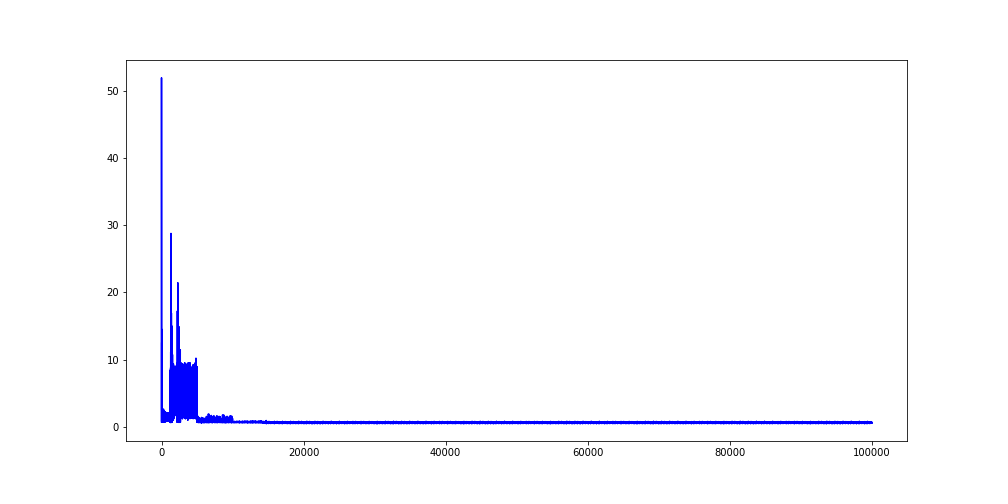

====== Test Report ======
First-order accuracy: 61.2%


In [295]:
number_of_iterations = 100001
report_frequency = 1000
epoch = 0
data_index = 0

with tf.Session(graph=BiLSTM_graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    losses = list()
    for iteration in range(number_of_iterations):
        last_epoch = epoch
        batch_data, batch_labels, epoch = generate_LSTM_batch(train_data, 
                                                              train_labels, 
                                                              batch_size,
                                                              sequence_length,
                                                              vector_dimension)
        if epoch > last_epoch and epoch % 10 == 0:
            print('Epoch %d complete.' % epoch)
            print(recent_prediction)
        feed_dict = {T : batch_data, Tlabel : batch_labels}
        _, l, train_predictions, lr = session.run([optimizer, loss, train_predict, learning_rate], feed_dict=feed_dict)
        losses.append(l)
        recent_prediction = first_order_accuracy(train_predictions, batch_labels)
    # last_attention_coeff = S.eval(feed_dict = feed_dict)
    
    show_losses = True
    if show_losses:
        plt.figure(figsize=(14,7))
        plt.plot(losses, color = 'b')
        plt.show()
    test = True
    if test:
        test_predictions = test_predict.eval()
        test_acc1 = first_order_accuracy(test_predictions, test_labels)
        print('====== Test Report ======')
        print('First-order accuracy: %.1f%%' % test_acc1)

In [296]:
def most_likely_unstable(predictions, labels, n_most):
    # look through pedictions and report the data-points that have the highest probability of being unstable
    combined = np.concatenate((predictions, labels), axis = 1)
    other = combined[combined[:,0].argsort()]
    for i in range(n_most):
        print(other[i])

most_likely_unstable(test_predictions, test_labels, len(test_labels))

[0.27872935 0.72127068 1.         0.        ]
[0.28173101 0.71826899 1.         0.        ]
[0.28173223 0.7182678  1.         0.        ]
[0.28173834 0.71826166 1.         0.        ]
[0.28181049 0.71818954 1.         0.        ]
[0.28185573 0.71814424 1.         0.        ]
[0.28197548 0.71802461 1.         0.        ]
[0.28200144 0.7179985  1.         0.        ]
[0.28207025 0.71792972 1.         0.        ]
[0.28286022 0.71713978 1.         0.        ]
[0.28310862 0.71689135 1.         0.        ]
[0.28332284 0.71667725 1.         0.        ]
[0.28388339 0.71611655 1.         0.        ]
[0.28389624 0.71610373 1.         0.        ]
[0.28425336 0.71574664 1.         0.        ]
[0.28431082 0.71568918 1.         0.        ]
[0.28525963 0.71474034 1.         0.        ]
[0.28530446 0.71469551 1.         0.        ]
[0.28536218 0.71463782 1.         0.        ]
[0.28559771 0.71440226 1.         0.        ]
[0.28589785 0.71410215 1.         0.        ]
[0.28599593 0.71400404 1.         

[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         1.        ]
[0.29864088 0.70135915 0.         

[0.33628461 0.66371542 1.         0.        ]
[0.33679569 0.66320431 1.         0.        ]
[0.33705866 0.66294134 1.         0.        ]
[0.33830726 0.66169274 1.         0.        ]
[0.33867416 0.66132575 1.         0.        ]
[0.33982921 0.66017079 1.         0.        ]
[0.33999932 0.66000074 1.         0.        ]
[0.34048593 0.65951407 1.         0.        ]
[0.34272662 0.65727341 1.         0.        ]
[0.34326985 0.65673012 1.         0.        ]
[0.34370041 0.65629959 1.         0.        ]
[0.3445482  0.65545189 1.         0.        ]
[0.34463394 0.65536606 1.         0.        ]
[0.34468293 0.65531707 1.         0.        ]
[0.34513131 0.65486872 1.         0.        ]
[0.34520587 0.6547941  1.         0.        ]
[0.34545729 0.65454274 1.         0.        ]
[0.34557447 0.6544255  1.         0.        ]
[0.34593999 0.65406001 0.         1.        ]
[0.34593999 0.65406001 0.         1.        ]
[0.34593999 0.65406001 0.         1.        ]
[0.34593999 0.65406001 0.         

[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         

[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         

[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         

[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 0.         1.        ]
[0.68904966 0.31095028 1.         0.        ]
[0.68904966 0.31095028 1.         

### Develop method to examine test results, look into mistakes, confusion matrix, timestep inclusion. 

### Test with muted embeddings. Transformer architecture owed. 